In [37]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn
import numpy as np
import pickle
import time
import os
import scipy.interpolate as spi

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [38]:
problem = {
    'num_vars': 5,
    'names': ["alpha", "prob_health_decrease", "prob_health_increase", "gamma", "w_delta_scale"],
    'bounds': [[0,1], [0,1], [0,1], [0.4,0.8], [0,1]]
}

### Sen's Welfare Function

In [19]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [21]:
result_dir = "results_exp_health_cost_delta"
sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open("sen_welfare.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [22]:
with open("sen_welfare.pickle", "rb") as f:
    sen_results = pickle.load(f)

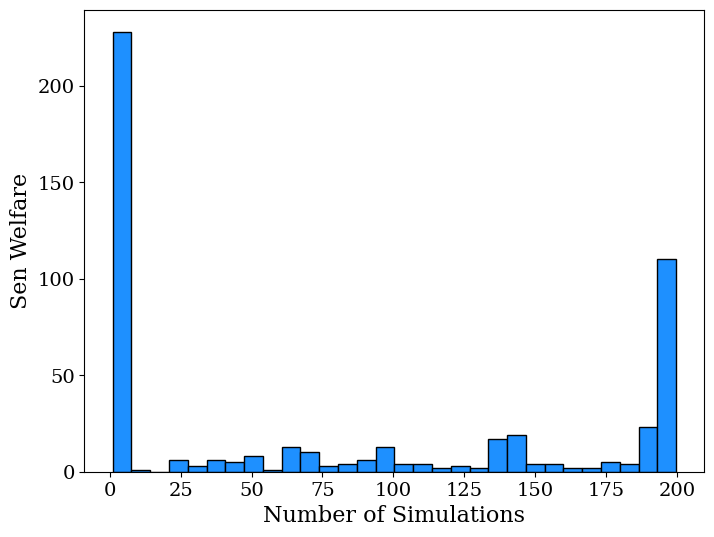

In [23]:
plt.hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.ylabel("Sen Welfare")
plt.xlabel("Number of Simulations")
plt.show()

In [25]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)

In [26]:
pawn.analyze(problem, X, Y, S=10, print_to_console=False)

/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


{'minimum': array([0.23828125, 0.05545343, 0.05786612, 0.06571691, 0.07720588]),
 'mean': array([0.44650942, 0.13076246, 0.12437135, 0.10305017, 0.19526684]),
 'median': array([0.44856771, 0.12331495, 0.1216682 , 0.0937883 , 0.16974954]),
 'maximum': array([0.66105769, 0.25268076, 0.20928486, 0.14713542, 0.43734976]),
 'CV': array([0.26512851, 0.41995722, 0.38203007, 0.3119124 , 0.51956034]),
 'names': ['alpha',
  'prob_health_decrease',
  'prob_health_increase',
  'gamma',
  'w_delta_scale']}

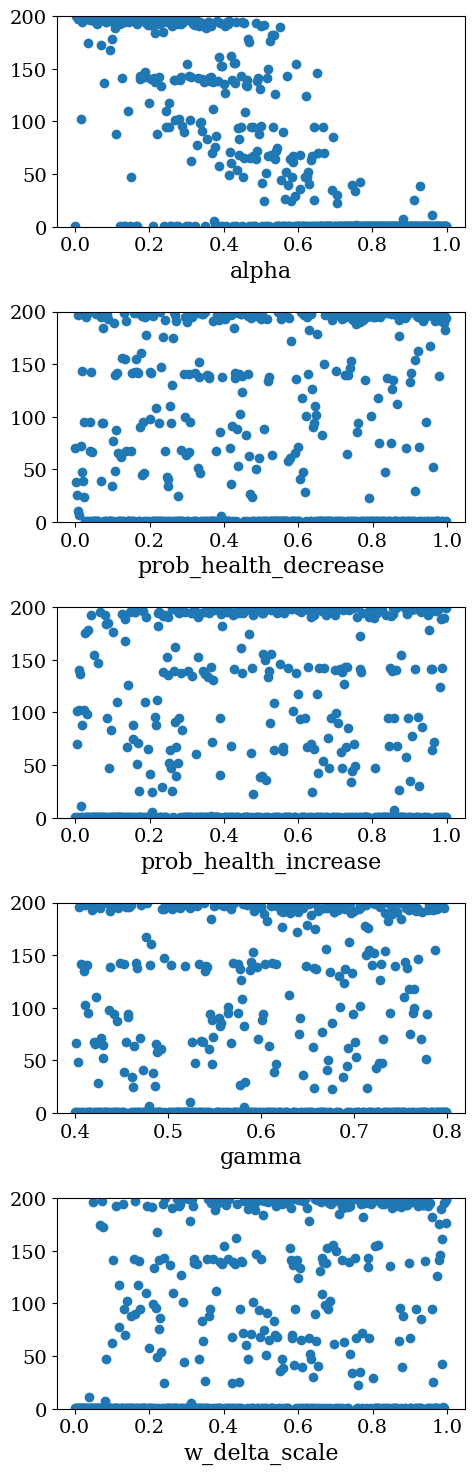

In [27]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,15))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
    axs[idx].set_ylim(0,200)
fig.tight_layout()
plt.show()

### MFPT

In [36]:
def compute_MFPT(n_steps, n_simulations, start_pos, target_pos, step_size, interpolate):
    rand_nums = np.random.uniform(0, 1, size=(n_steps, n_simulations))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps, n_simulations))

    target_x = np.full(n_simulations, target_pos[0])
    target_y = np.full(n_simulations, target_pos[1])

    X = np.zeros((n_simulations, n_steps+1))
    X[:,0] = start_pos[0]
    Y = np.zeros((n_simulations, n_steps+1))
    Y[:,0] = start_pos[1]

    still_moving = np.ones((n_simulations,))
    FPT = np.full_like(np.zeros(n_simulations,), n_steps)
    
    current_potential = interpolate(X[:,0], Y[:,0], grid=False)

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size
        new_potential = interpolate(X[:,step] + dx, Y[:,step] + dy, grid=False)

        # check whether to accept or reject moves
        accept = np.logical_or(new_potential < current_potential, rand_nums[step] < np.exp(current_potential - new_potential))
        current_potential = new_potential

        # update position
        X[:,step+1] = X[:,step] + accept * dx * still_moving
        Y[:,step+1] = Y[:,step] + accept * dy * still_moving

        reached_target = (X[:,step+1] - target_x)**2 + (Y[:,step+1] - target_y)**2 < step_size**2
        FPT = np.where(np.logical_and(still_moving, reached_target), step, FPT)
        still_moving = np.where(reached_target, 0, still_moving)

        if not np.any(still_moving):
            break

    return FPT.mean()

In [34]:
result_dir = "results_exp_health_cost_delta"

interpolation_functions = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open("interpolation_functions.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [29]:
MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima(func, count_threshold=2, num_points=15, N=param_set["N"], step_size=10))
    )
with open("minima.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/512 [00:00<?, ?it/s]

In [30]:
with open("minima.pickle", "rb") as f:
    MINIMA = pickle.load(f)

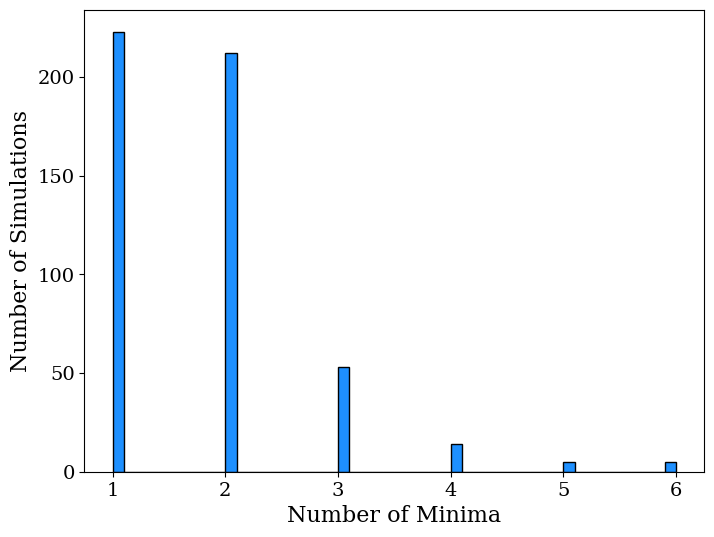

In [31]:
plt.hist(
    [len(m[1]) for m in MINIMA],
    bins=50,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.show()

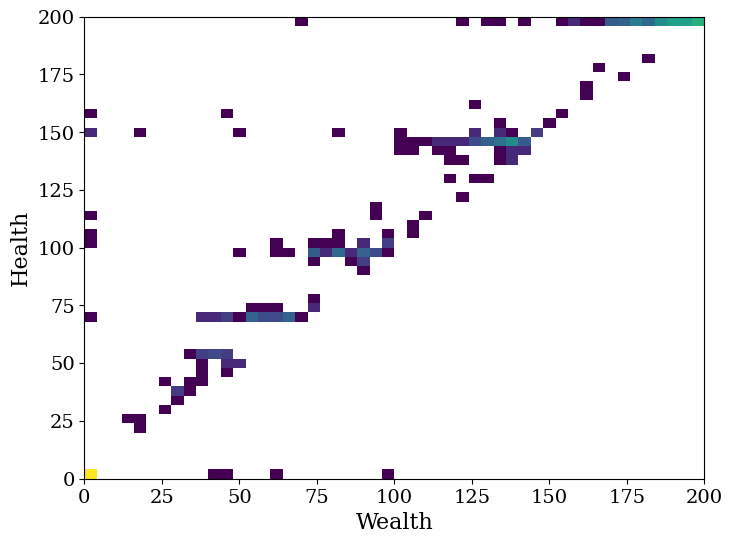

In [32]:
minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])

plt.hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)

plt.xlabel("Wealth")
plt.ylabel("Health")
plt.show()

In [39]:
MFPT_results = []
for simulation_idx, item in tqdm(enumerate(MINIMA)):
    params, minima_list = item
    assert len(minima_list) > 0
    result = {}
    for i in range(len(minima_list)):
        w_i, h_i = minima_list[i][0]
        for j in range(i+1, len(minima_list)):
            w_j, h_j = minima_list[j][0]
            func = interpolation_functions[simulation_idx][1]
            delta_utility = func(w_j, h_j) - func(w_i, h_i)
            mfpt = compute_MFPT(
                n_steps=1000,
                n_simulations=100,
                start_pos=(w_i, h_i),
                target_pos=(w_j, h_j),
                step_size=1,
                interpolate=func
            )
            result[((w_i,h_i),(w_j,h_j))] = {
                "delta_util" : delta_utility,
                "mfpt" : mfpt
            }
    MFPT_results.append((params, result))

0it [00:00, ?it/s]

In [40]:
with open("MFPT_results.pickle", "wb") as f:
    pickle.dump(MFPT_results, f)

### Investigate final state space outcome as function of initial state

In [14]:
init_w = []
init_h = []

result_dir = "results_exp_health_cost_delta"
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]

    condition = (wealth[:,-1] < 5) & (health[:,-1] < 5)

    init_w.append(wealth[condition,0])
    init_h.append(health[condition,0])

  0%|          | 0/512 [00:00<?, ?it/s]

In [15]:
init_w = np.concatenate(init_w)
init_h = np.concatenate(init_h)

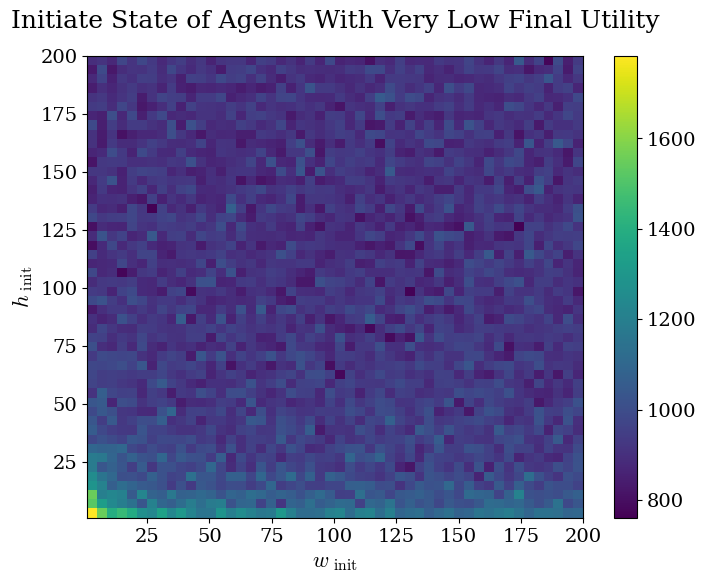

In [16]:
fig, ax = plt.subplots()
h = ax.hist2d(init_w, init_h, bins=50)
fig.colorbar(h[3], ax=ax)

plt.xlabel(r"$w_{\text{ init}}$")
plt.ylabel(r"$h_{\text{ init}}$")
plt.title("Initiate State of Agents With Very Low Final Utility", pad=20)
plt.show()